In [2]:
import intake
from easygems import healpix as egh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import splprep, splev
import healpy as hp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ellipse import LsqEllipse
import xarray as xr

In [3]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["online"]
ds = cat['um_glm_n2560_RAL3p3'](zoom=2).to_dask()
ds_ocean = ds.where(ds.sftlf<0.5).sel(time=slice('2020-03-01T00:00:00','2021-03-01T00:00:00'))[['uas','vas', 'sftlf']] #
ds_winds = ds_ocean.groupby('time.hour').mean()
ds_winds = ds_winds.assign(ws = np.sqrt(ds_winds.uas**2 + ds_winds.vas**2))

/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<Figure size 640x480 with 0 Axes>

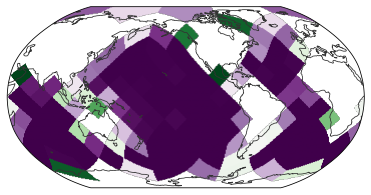

In [4]:
egh.healpix_show(ds_winds["sftlf"].sel(hour = 0), cmap = "PRGn", dpi=72)

In [62]:
import numpy.linalg as la
import logger

def fit(X):
        """Fit the data

        Parameters
        ----------
        X : array, shape (n_points, 2)
            Data values for the x-y data pairs to fit

        Returns
        -------
        self : returns an instance of self.
        """

        # extract x-y pairs
        x, y = X.T

        # Quadratic part of design matrix [eqn. 15] from (*)
        D1 = np.vstack([x**2, x*y, y**2]).T
        # Linear part of design matrix [eqn. 16] from (*)
        D2 = np.vstack([x, y, np.ones_like(x)]).T

        # Forming scatter matrix [eqn. 17] from (*)
        S1 = D1.T @ D1
        S2 = D1.T @ D2
        S3 = D2.T @ D2

        # Constraint matrix [eqn. 18]
        C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

        # Reduced scatter matrix [eqn. 29]
        M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

        # M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this
        # equation [eqn. 28]
        eigval, eigvec = np.linalg.eig(M)

        # Eigenvector must meet constraint 4ac - b^2 to be valid.
        cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
        a1 = eigvec[:, np.nonzero(cond > 0)[0]]

        # |d f g> = -S3^(-1) * S2^(T)*|a b c> [eqn. 24]
        a2 = la.inv(-S3) @ S2.T @ a1

        # Eigenvectors |a b c d f g>
        # list of the coefficients describing an ellipse [a,b,c,d,e,f]
        # corresponding to ax**2 + bxy + cy**2 + dx + ey + f from (*)
        #self.coef_ = np.vstack([a1, a2])

        """Returns the definition of the fitted ellipse as localized parameters

        Returns
        _______
        center : tuple
            (x0, y0)
        width : float
            Total length (diameter) of horizontal axis.
        height : float
            Total length (diameter) of vertical axis.
        phi : float
            The counterclockwise angle [radians] of rotation from the x-axis to the semimajor axis
        """

        # Eigenvectors are the coefficients of an ellipse in general form
        # the division by 2 is required to account for a slight difference in
        # the equations between (*) and (**)
        # a*x^2 +   b*x*y + c*y^2 +   d*x +   e*y + f = 0  (*)  Eqn 1
        # a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0  (**) Eqn 15
        # We'll use (**) to follow their documentation
        a = np.vstack([a1,a2])[0]
        b = np.vstack([a1,a2])[1] / 2.
        c = np.vstack([a1,a2])[2]
        d = np.vstack([a1,a2])[3] / 2.
        f = np.vstack([a1,a2])[4] / 2.
        g = np.vstack([a1,a2])[5]

        # Finding center of ellipse [eqn.19 and 20] from (**)
        x0 = (c*d - b*f) / (b**2 - a*c)
        y0 = (a*f - b*d) / (b**2 - a*c)
        center = (x0, y0)

        # Find the semi-axes lengths [eqn. 21 and 22] from (**)
        numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
        denominator1 = (b**2 - a*c) * ( np.sqrt((a-c)**2+4*b**2) - (c+a))  # noqa: E201
        denominator2 = (b**2 - a*c) * (-np.sqrt((a-c)**2+4*b**2) - (c+a))
        height = np.sqrt(numerator / denominator1)
        width = np.sqrt(numerator / denominator2)

        # Angle of counterclockwise rotation of major-axis of ellipse to x-axis
        # [eqn. 23] from (**)
        # w/ trig identity eqn 9 form (***)
        if b == 0 and a > c:
            phi = 0.0
        elif b == 0 and a < c:
            phi = np.pi/2
        elif b != 0 and a > c:
            phi = 0.5 * np.arctan(2*b/(a-c))
        elif b != 0 and a < c:
            phi = 0.5 * (np.pi + np.arctan(2*b/(a-c)))
        elif a == c:
            logger.warning("Ellipse is a perfect circle, the answer is degenerate")
            phi = 0.0
        else:
            raise RuntimeError("Unreachable")

        return center, width, height, phi

        #return np.vstack([a1, a2])

ModuleNotFoundError: No module named 'logger'

In [61]:
points = np.array(list(zip(x_ds[::2], y_ds[::2])))
center, width, height, phi = fit(points)
#elip.as_parameters()

IndexError: tuple index out of range

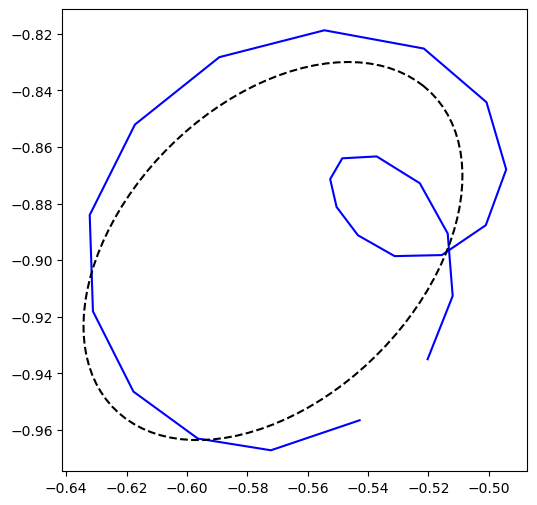

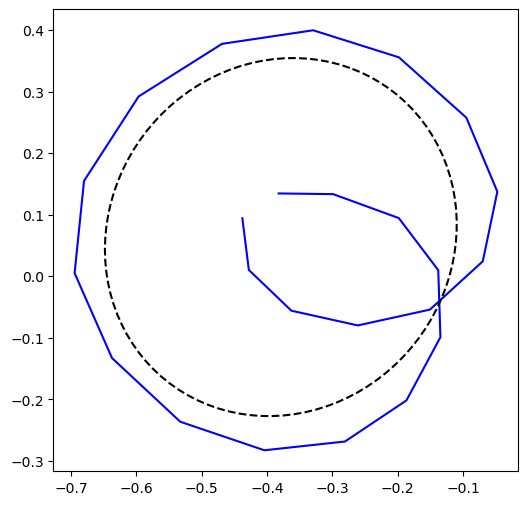

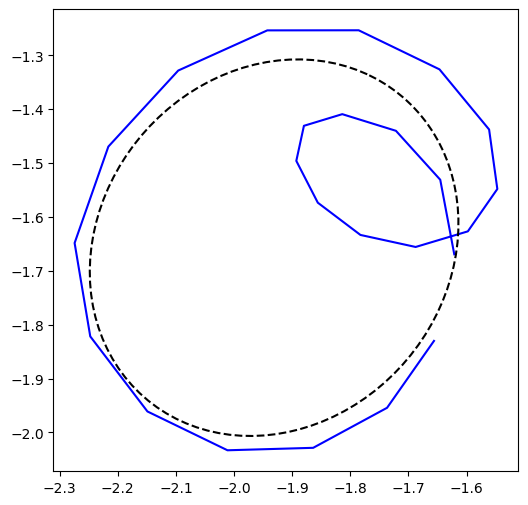

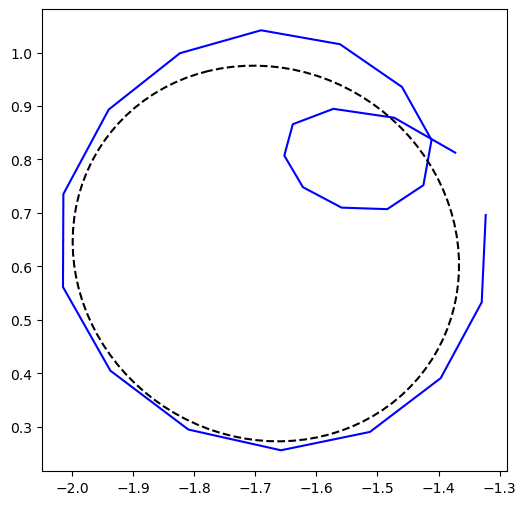

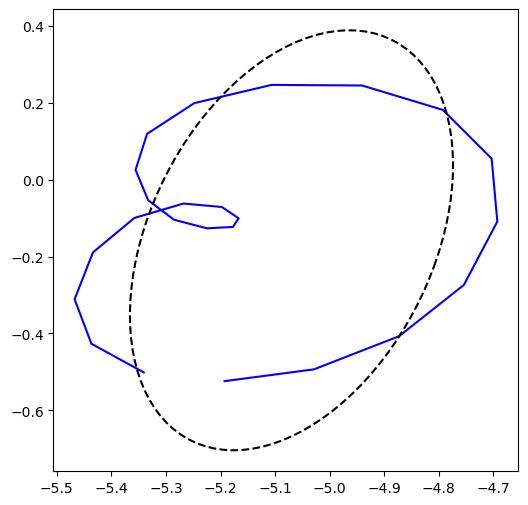

In [45]:
for cl in range(0,100,5):
    if np.isnan(ds_winds.isel(cell=cl).uas).all() == False:
        x_ds = ds_winds.isel(cell=cl).uas.to_numpy()
        y_ds = ds_winds.isel(cell=cl).vas.to_numpy()

        points = np.array(list(zip(x_ds[::2], y_ds[::2])))
        elip = LsqEllipse().fit(points)
        center, width, height, phi = elip.as_parameters()
        u0, v0 = center
        u1 = width * np.cos(phi)
        u2 = -height * np.sin(phi)
        v1 = width * np.sin(phi)
        v2 = height * np.cos(phi)
        t = np.linspace(0, 2 * np.pi, 100)
        uelip = u0 + u1 * np.cos(t) + u2 * np.sin(t)
        velip = v0 + v1 * np.cos(t) + v2 * np.sin(t)


        plt.figure(figsize=(6,6))
        plt.plot(x_ds, y_ds, c='b')
        plt.plot(uelip,velip, color="k", ls="--")

In [5]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    Interpolate from healpix to regular lat lon
    
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )


In [ ]:
#Get the "nside", which is used for regridding
nside = hp.get_nside(ds_winds.uas)

#Set up target latitude and longitude (regular grid) to interpolate onto
target_lats = np.linspace(
    -90,
    90,
    20
)
target_lons = np.linspace(
    0,
    360,
    20
)

target_inds = get_nn_lon_lat_index(nside, target_lons, target_lats)

ds_latlon = ds_winds.isel(cell=target_inds)

In [71]:
num = 2* (u1*u2 + v1*v2)
den = u1**2 + v1**2 - u2**2 - v2**2
omega = 0.5*np.arctan(num/den)
theta = np.arctan((v1*np.cos(omega) + v2*np.sin(omega)) / (u1*np.cos(omega) - u2*np.sin(omega)))

print(omega, theta)

3.71267273583237e-17 -1.2198545366323454


In [52]:
def normalize_array(arr, min, max):
    arr = arr + np.abs(min)
    norm_arr = (arr - min) / (max - min)
    return norm_arr

def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/

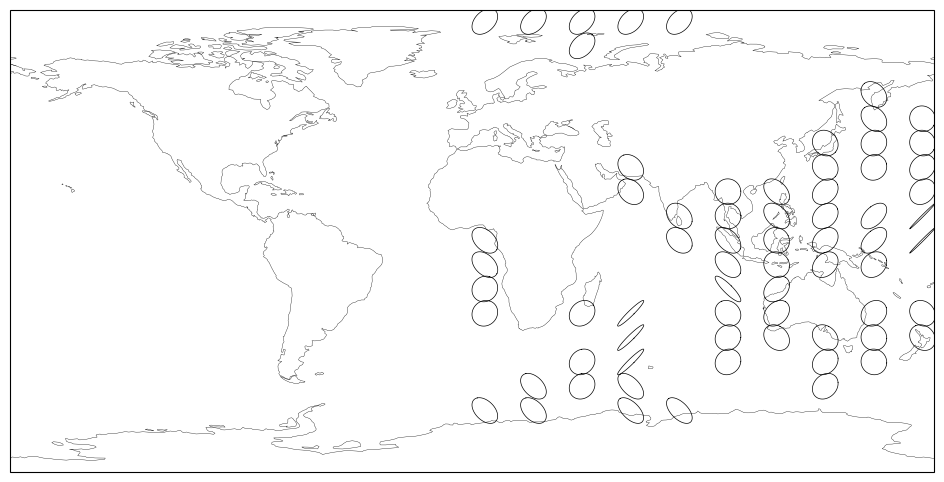

In [54]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(linewidth=0.25)
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#ax.gridlines(draw_labels=True)

for lat in target_lats:
    for lon in target_lons:
        if np.isnan(ds_latlon.sel(lat=lat,lon=lon).uas).all() == False:
            x_ds = ds_latlon.sel(lat=lat,lon=lon).uas.to_numpy()
            y_ds = ds_latlon.sel(lat=lat,lon=lon).vas.to_numpy()
            points = np.array(list(zip(x_ds[::2], y_ds[::2])))
            min = -7
            max = 7
            try:
                elip = LsqEllipse().fit(points)
                center, width, height, phi = elip.as_parameters()
                u0, v0 = center

                u1 = width * np.cos(phi)
                u2 = -height * np.sin(phi)
                v1 = width * np.sin(phi)
                v2 = height * np.cos(phi)

                t = np.linspace(0, 2 * np.pi, 100)
                uelip = normalize_array(u0 + u1 * np.cos(t) + u2 * np.sin(t))
                velip = normalize_array(v0 + v1 * np.cos(t) + v2 * np.sin(t))
                
                #plt.plot(x_ds, y_ds, c='b')
                ax.plot((uelip*10)+lon,(velip*10)+lat, color="k", linewidth=0.5)
                
            except:
                continue

In [ ]:



type(uelip)

numpy.ndarray

(-90.0, 90.0)

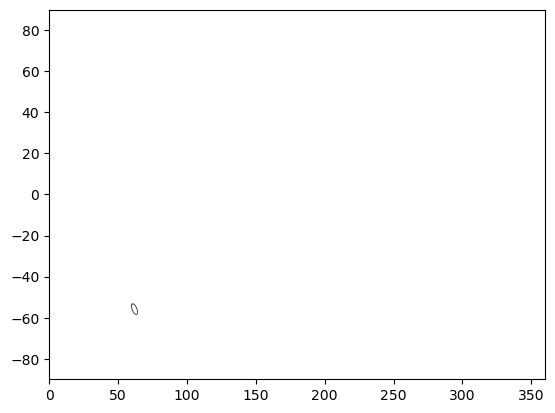

In [29]:
plt.plot((uelip*10)+lon,(velip*10)+lat, color="k", linewidth=0.5)
plt.xlim(0,360)
plt.ylim(-90,90)

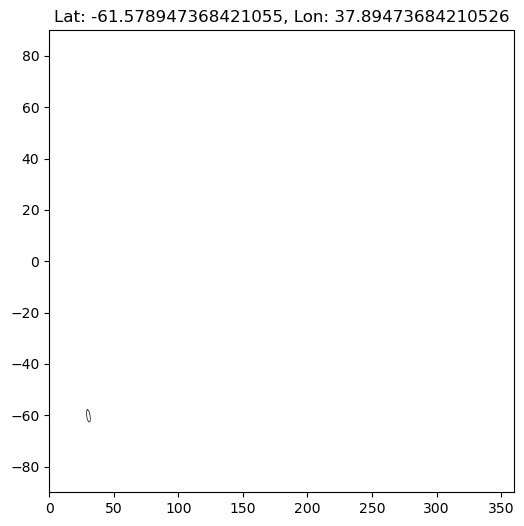

In [21]:
plt.figure(figsize=(6,6))
#plt.plot(x_ds, y_ds, c='b')
plt.plot((uelip*10)+lon,(velip*10)+lat, color="k", linewidth=0.5)
plt.title(f"Lat: {lat}, Lon: {lon}")
plt.xlim(0,360)
plt.ylim(-90,90)
plt.show()

/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/

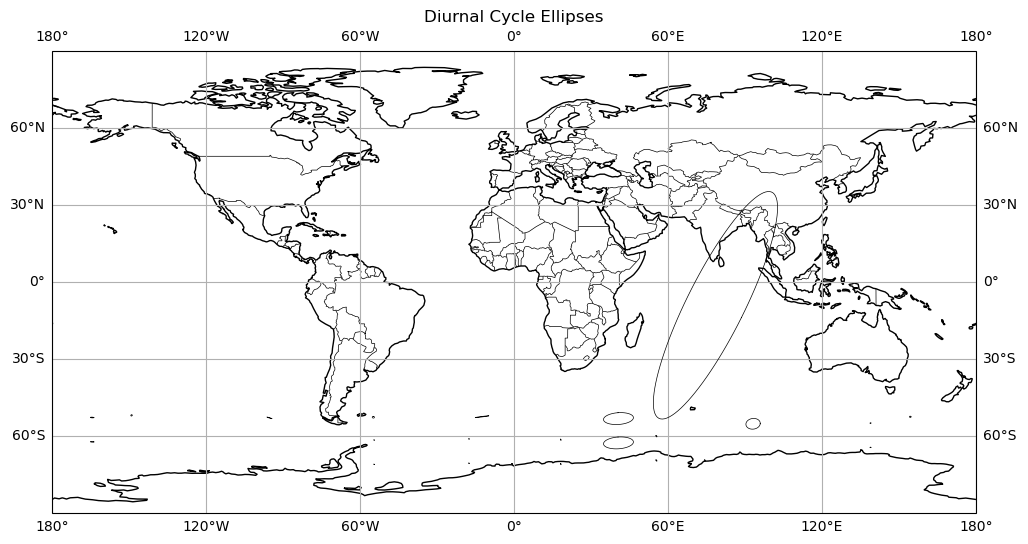

In [67]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True)

for lon, lat, uelip, velip in ellipse_data:
    ax.plot(uelip + lon, velip + lat, 'k-', linewidth=0.5, transform=ccrs.PlateCarree())

plt.title("Diurnal Cycle Ellipses")
plt.show()


In [49]:
((ds.sftlf.isel(cell=target_inds))>0.5)#.plot(ax=ax, transform = ccrs.PlateCarree())

<xarray.DataArray 'sftlf' (lat: 20, lon: 20)> Size: 400B
dask.array<gt, shape=(20, 20), dtype=bool, chunksize=(9, 20), chunktype=numpy.ndarray>
Coordinates:
    cell     (lat, lon) int64 3kB 128 128 128 128 128 144 ... 47 63 63 63 63 15
    crs      float64 8B ...
  * lat      (lat) float64 160B -90.0 -80.53 -71.05 -61.58 ... 71.05 80.53 90.0
  * lon      (lon) float64 160B 0.0 18.95 37.89 56.84 ... 322.1 341.1 360.0

In [ ]:
im=((ds.sftlf.isel(cell=target_inds))>0.5).plot(ax=ax, transform = ccrs.PlateCarree())
ax.coastlines()

<xarray.DataArray (lat: 20, lon: 20)> Size: 3kB
array([[128, 128, 128, 128, 128, 144, 144, 144, 144, 144, 160, 160, 160,
        160, 160, 176, 176, 176, 176, 128],
       [128, 128, 128, 128, 128, 144, 144, 144, 144, 144, 160, 160, 160,
        160, 160, 176, 176, 176, 176, 128],
       [130, 130, 128, 129, 129, 146, 146, 144, 145, 145, 162, 162, 160,
        161, 161, 178, 178, 176, 177, 130],
       [136, 130, 131, 129, 132, 152, 146, 147, 145, 148, 168, 162, 163,
        161, 164, 184, 178, 179, 177, 136],
       [138, 136, 131, 134, 132, 154, 152, 147, 150, 148, 168, 169, 163,
        164, 165, 184, 185, 179, 180, 138],
       [138, 138, 137, 134, 133, 154, 153, 153, 150, 149, 170, 169, 166,
        166, 165, 186, 185, 182, 181, 138],
       [ 64, 139, 140, 134, 133,  80, 155, 156, 151, 149, 170, 171, 172,
        167, 112, 186, 185, 188, 183,  64],
       [ 64, 139, 142, 141,  82,  81, 155, 156, 157,  98,  97, 174, 172,
        167, 114, 113, 190, 189, 183,  64],
       [ 67,  68, 142, 141,  82,  83,  84, 159, 104,  98,  97, 100, 175,
        120, 115, 113, 190, 189,  72,  67],
       [ 67,  68,  69,  90,  89,  83,  84, 159, 106, 105, 102, 101, 175,
        120, 115, 118, 117,  74,  72,  67],
       [ 76,  71,  69,  90,  89,  92,  87,  16, 106, 105, 102, 101,  32,
        123, 124, 118, 117,  74,  75,  76],
       [ 76,  71,   2,   1,  94,  92,  87,  16, 107, 110, 109, 103,  32,
        123, 124, 125,  50,  49,  75,  76],
       [ 79,   8,   2,   1,  94,  93,  24,  19,  17, 110, 109,  34,  35,
         36, 126, 125,  50,  49,  52,  79],
       [ 79,   8,   3,   6,   5,  95,  24,  19,  20,  21,  42,  40,  35,
         36, 127,  58,  57,  51,  52,  79],
       [ 10,  10,   9,   6,   5,  26,  25,  25,  22,  21,  42,  41,  38,
         38,  37,  58,  57,  54,  53,  10],
       [ 10,  11,  12,   6,   7,  26,  27,  28,  22,  23,  43,  41,  44,
         39,  37,  59,  57,  60,  55,  10],
       [ 11,  14,  12,  13,   7,  27,  30,  28,  29,  23,  43,  46,  44,
         45,  39,  59,  62,  60,  61,  11],
       [ 14,  14,  15,  13,  13,  30,  30,  31,  29,  29,  46,  46,  47,
         45,  45,  62,  62,  63,  61,  14],
       [ 15,  15,  15,  15,  15,  31,  31,  31,  31,  31,  47,  47,  47,
         47,  47,  63,  63,  63,  63,  15],
       [ 15,  15,  15,  15,  15,  31,  31,  31,  31,  31,  47,  47,  47,
         47,  47,  63,  63,  63,  63,  15]])
Coordinates:
  * lat      (lat) float64 160B -90.0 -80.53 -71.05 -61.58 ... 71.05 80.53 90.0
  * lon      (lon) float64 160B 0.0 18.95 37.89 56.84 ... 322.1 341.1 360.0